# Chapter 10: Quantifying effects and designing studies

In [1]:
import pandas as pd
import sidetable
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm, t, binom, ttest_ind, bootstrap
import pingouin as pg
import matplotlib
from statsmodels.stats.power import TTestIndPower

import rpy2.robjects as ro
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri
pandas2ri.activate()
from rpy2.robjects.conversion import localconverter
# import NHANES package
base = importr('NHANES')

with localconverter(ro.default_converter + pandas2ri.converter):
  NHANES = ro.conversion.rpy2py(ro.r['NHANES'])

 
NHANES = NHANES.drop_duplicates(subset='ID')
NHANES_adult = NHANES.dropna(subset=['PhysActive', 'Weight', 'BPSysAve', 'Height']).query('Age > 17 and BPSysAve > 0')

rng = np.random.default_rng(1234)


## Figure 10.1

Text(0.5, 0, 'samples')

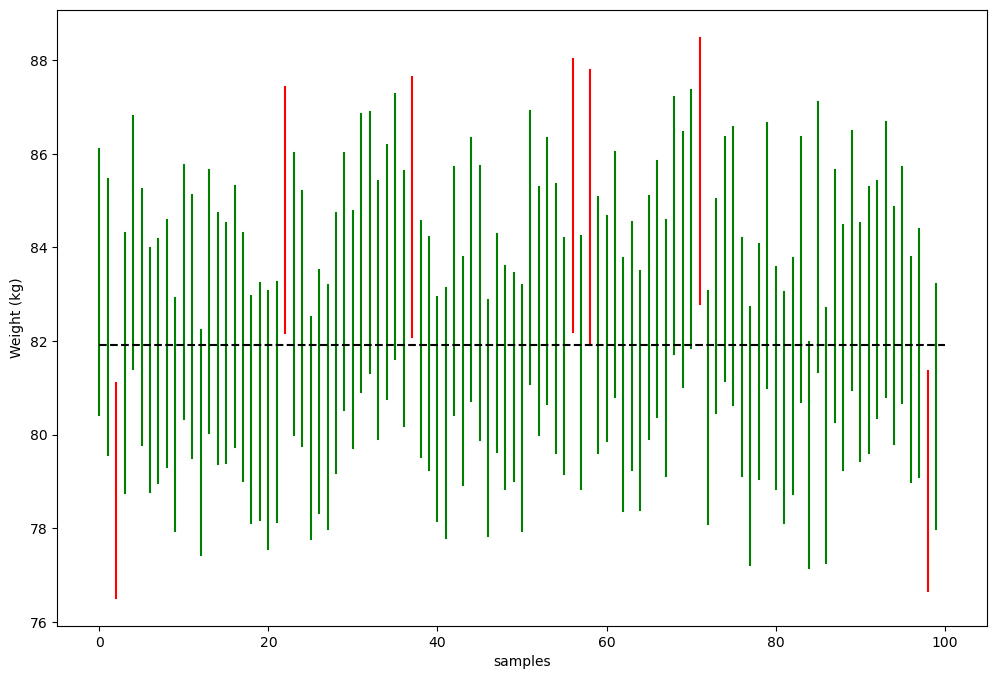

In [2]:
sample_ci = []
sampSize = 250

nsamples = 100
cutoff_lower = t.ppf(0.025, sampSize - 1)
cutoff_upper = t.ppf(0.975, sampSize - 1)
popMean = NHANES_adult.Weight.mean()

for i in range(nsamples):
    samp = NHANES_adult.sample(sampSize, random_state=rng).Weight
    SEM = samp.std() / np.sqrt(sampSize)
    ci_lower = samp.mean() + cutoff_lower * SEM
    ci_upper = samp.mean() + cutoff_upper * SEM
    sample_ci.append([ci_lower, ci_upper, ci_upper > popMean and ci_lower < popMean ])
    
sample_ci_df = pd.DataFrame(sample_ci, columns=['ci_lower', 'ci_upper', 'CI captures mean'])

fig = plt.figure(figsize=(12,8))
for i in range(nsamples):
    plt.plot([i, i], [sample_ci_df.loc[i, 'ci_lower'], sample_ci_df.loc[i, 'ci_upper']],
             color='green' if sample_ci_df.loc[i, 'CI captures mean'] else 'red')
# plt.legend(['True', 'False'], title='CI captures mean')
plt.plot([0, nsamples], [popMean, popMean], color='k', linestyle='dashed')
plt.ylabel('Weight (kg)')
plt.xlabel('samples')

## Figure 10.2

Text(0, 0.5, 'Mean Weight')

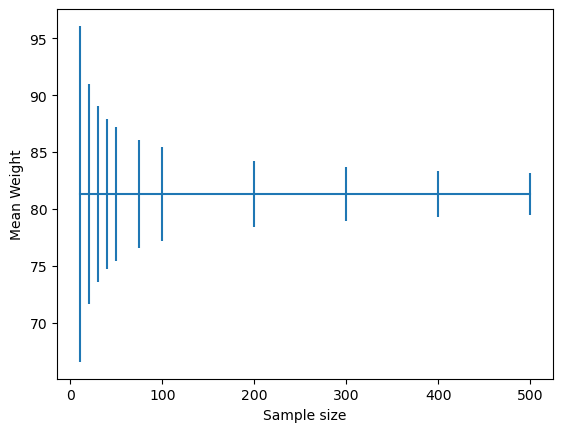

In [3]:
NHANES_sample = NHANES_adult.sample(sampSize)

meanWeight = NHANES_sample.Weight.mean()

ssDf = pd.DataFrame({'sampSize': [10,20,30,40,50,75,100,200,300,400,500]})
ssDf['meanWeight'] = meanWeight
ssDf['ci_lower'] = t.ppf(0.025, ssDf.sampSize - 1) * NHANES_sample.Weight.std() / np.sqrt(ssDf.sampSize)
ssDf['ci_upper'] = t.ppf(0.975, ssDf.sampSize - 1) * NHANES_sample.Weight.std() / np.sqrt(ssDf.sampSize)

plt.errorbar(x=ssDf.sampSize, y=ssDf.meanWeight, yerr = ssDf[['ci_upper']].values.T)
plt.xlabel("Sample size")
plt.ylabel( "Mean Weight")


Bootstrap confidence intervals

In [4]:
bs = bootstrap((NHANES_sample.Weight.values,), statistic=np.mean, method='percentile',
         random_state=rng)
bs.confidence_interval

ConfidenceInterval(low=78.81678, high=83.84303999999997)

## Figure 10.3

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-15.921999,247.381569,greater,1.0,"[-15.79, inf]",2.007968,2.655e-37,0.0


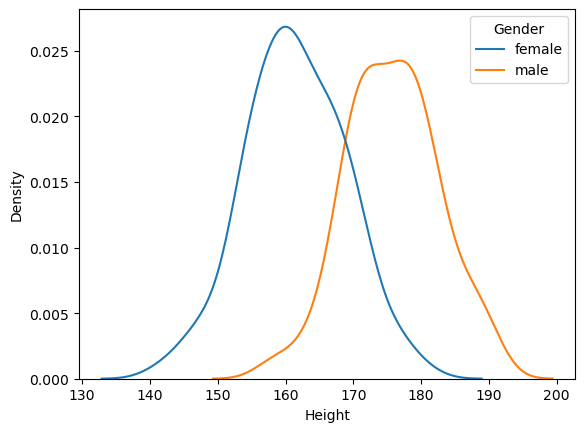

In [5]:
sns.kdeplot(data=NHANES_sample, x='Height', hue='Gender')

tt = pg.ttest(x=NHANES_sample.query('Gender == "female"').Height, 
              y=NHANES_sample.query('Gender == "male"').Height,
              alternative='greater', correction=True)
tt

## Figure 10.4

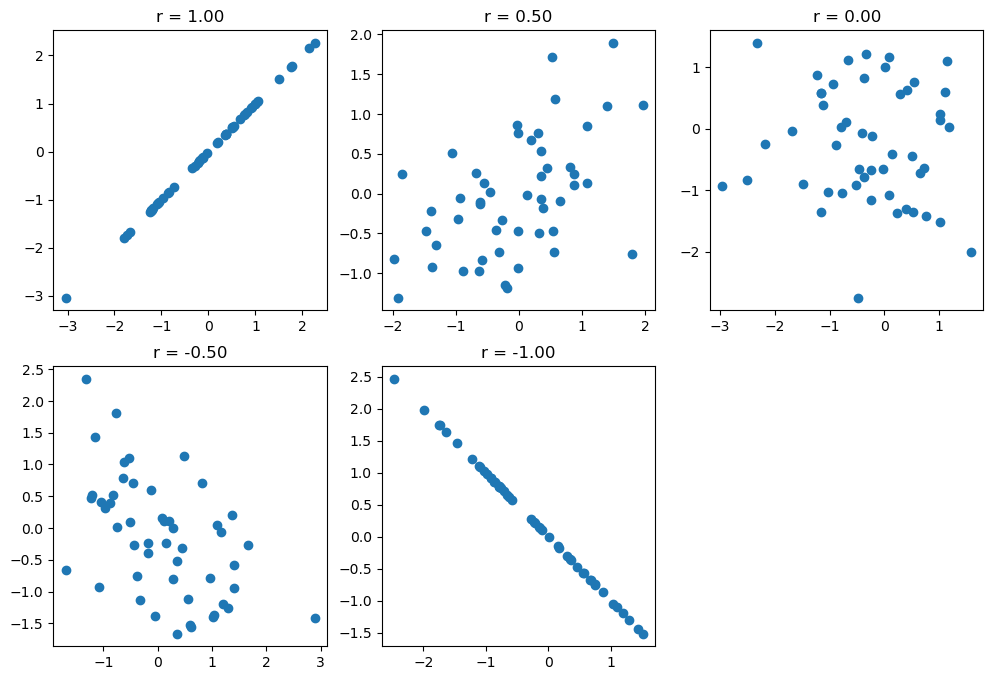

In [6]:
fig, ax = plt.subplots(2, 3, figsize=(12,8))

corrvals = [1,0.5,0,-0.5,-1]

for i in range(2):
    for j in range(3):
        idx = i * 3 + j
        if idx >= len(corrvals):
            continue
        corr = corrvals[idx]
        simdata = np.random.multivariate_normal(
            mean=[0, 0], 
            cov = [[1, corr], [corr, 1]],
            size = 50)
        ax[i][j].scatter(simdata[:, 0], simdata[:, 1])
        ax[i][j].set_title(f'r = {corr:.2f}')

ax[1][2].set_visible(False)

## Figure 10.5

In [7]:
powervals = [(s, e, a) for s in [12, 24, 48, 96] for e in [.2, .5, .8] for a in [0.005, 0.05]]
powerDf = pd.DataFrame(powervals, columns=['sampSizePerGroup', 'effectSize', 'alpha'])

def runPowerSim(sampSizePerGroup, effectSize, alpha, nsims=1000):
    p = []
    for i in range(nsims):
        a = rng.normal(size=sampSizePerGroup)
        b = rng.normal(size=sampSizePerGroup) + effectSize
        p.append(pg.ttest(x=a, y=b,correction=True)['p-val'][0])
    return(np.mean(np.array(p) < alpha))

powerDf['power'] = None
for i in powerDf.index:
    powerDf.loc[i, 'power'] = runPowerSim(
        powerDf.loc[i, 'sampSizePerGroup'],
        powerDf.loc[i, 'effectSize'],
        powerDf.loc[i, 'alpha'])

<AxesSubplot:xlabel='sampSizePerGroup', ylabel='power'>

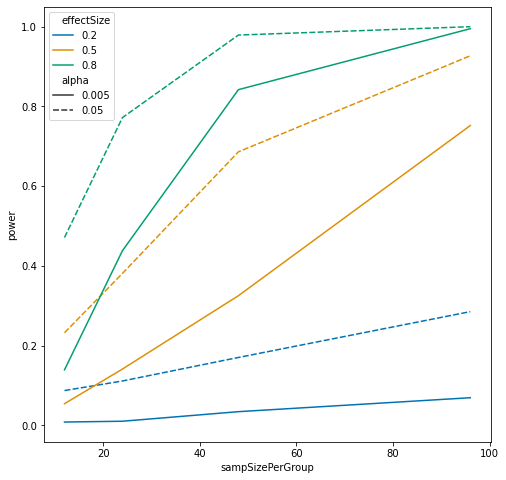

In [139]:
plt.figure(figsize=(8,8))
sns.lineplot(data=powerDf, x='sampSizePerGroup', 
             y='power', hue='effectSize', ci=None,
            style='alpha', palette='colorblind')

## Power analyses

In [105]:

obj = TTestIndPower()

n = obj.solve_power(effect_size=0.5, alpha=0.05, power=0.8, 
                    ratio=1, alternative='two-sided')
print(f'd = 0.5, n = {n:.2f} in each group')

n = obj.solve_power(effect_size=2, alpha=0.05, power=0.8, 
                    ratio=1, alternative='two-sided')
print(f'd = 2, n = {n:.2f} in each group')


d = 0.5, n = 63.77 in each group
d = 2, n = 5.09 in each group
